# A simple heat problem for Python-Post-Processing

This tutorial starts with a short description of the problem and how to simulate it with cfs. All needed files are provided. Afterwords some simple python postprocessing is done.

## Short description of problem

The geometry of the domain is a cylinder with the radius $r$ and the height $h$, due to symmetry reasons only on quarter is used for computation. The top volume is called `V_all` with the mantle surfaces `S_mantle` and the symmetry surfaces `S_x` and `S_y`. `S_top` is located on top of the cylinder and `S_bottom` on the bottom.

|Sketch of problem|
|:-:|
|![](mesh.png)|

`S_bottom` does have a prescribed temperature $T_{bot}$. We assume an ambient temperature of $T_{air}$ and a heat transfer coefficient $\alpha$. Furthermore the domain moves with a certain velocity $v$ forward. On `S_x` and `S_y` the heat flux is zero, due to symmetry reasons. Because the temperature of the surrounding air is lower that the initial temperature of the cylinder, the cylinder cools down, while moving forward.

| Description | Variable | Unit | Value |
|:-----------:|:--------:|:----:|:-----:|
|Density of iron|$\rho$|kg/m³|7874|
|Heat capacity of iron|$c$|J/(kg·K)|444|
|Heat conductivity of iron|$k$|W/(m·K)|79.5|
|Heat transfer coefficient|$\alpha$|W/(m²·K)|20|
|Heat source density|$\dot{q}_v$|J/m³|50|
|Bottom temperate|$T_{bot}$|K|293|
|Air temperature|$T_{air}$|K|273|
|Radius of cylinder|$r$|m|0.2|
|Height of cylinder|$l$|m|1|
|Velocity of cylinder|$v$|m/s|0.001|

## Simulation
Download these files:

- Journal file: [`mesh.jou`](mesh.jou)
- Material file: [`mat.xml`](mat.xml)
- Simulation file: [`simulation.xml`](simulation.xml)
 

Create the mesh using `mesh.jou` and Trelis and run the simulation with cfs:

- Terminal command for meshing: `trelis -batch -nographics -nojournal UnitCube.jou`
- Terminal command for simulation: `cfs simulation`

The simulation results should be in the `./results_hdf5/`.

## Postprocessing with pyhton
For Python-postprocessing we are going to use the python-library [`hdf5_tools.py`](https://gitlab.com/openCFS/cfs/-/blob/master/share/python/hdf5_tools.py). This library is also enrolled automatic with every openCFS-version and can be found under `/path/to/install/dir/CFS/share/python/hdf5_tools.py`.

In this tutorial we are going to use two functions from `hdf5_tools.py`:
* `get_result()`
* `get_coordinates()`

How each function works, is described in the according docstring.

Lets start with reading the nodal result (temperature) out of the CFS-file with `get_result()`:

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "./Devel/CFS_SRC/CFS/share/python/hdf")
from hdf5_tools import get_result

#Reading in the cfs-file, instert here the path to your cfs-file
hdf5=f'./results_hdf5/simulation.cfs'

#Reading the temperatue out of the cfs-file
T=get_result(hdf5,"heatTemperature", region="V_all", multistep=1)

After reading the CFS-file, the array `T` contains now the nodal temperature of all the nodes in the region `V_all`. Now we could simply search for the maximum and minimum temperature:

In [8]:
T_max=T.max()
print(f'The maximal temperature is {np.round(T_max,3)}°C.')
T_min=T.min()
print(f'The minimal temperature is {np.round(T_min,3)}°C.')

The maximal temperature is 20.0°C.
The minimal temperature is 19.189°C.


The maximal temperature is 20°C and its clear, that it occurs on the `S_bot` since we prescribed the temperature there

And where does the minimal temperature occurs? For this we going to use `get_coordinates()`.

In [5]:
from hdf5_tools import get_coordinates
# Getting the node, where the minimal temperature occurs
Idx_min=np.argwhere(T==T.min())

#Get the coordinates for each node
X=get_coordinates(hdf5, region="V_all")
#Pluggin in the indices for maximal and minimal temperatures:
X_min=X[Idx_min]
# Reshaping X_min
X_min=X_min.reshape(3)

print(f'The coordinates for the minimal temperature are {X_min} ([x,y,z])')

Great, but actually i want them in polar coordinates. Well thats quite simple to achieve:

In [10]:
#Quickly write a funtcion which convertes carthesian coord into clyindirc coords
def cart2pol(X):
    r=np.sqrt(X[0]**2 + X[1]**2)
    phi=np.arctan2(X[1],X[0])
    phi=phi*360/(2*np.pi)     #for degrees
    z=X[2]
    return [r,phi,z]

print(f'In radial coordinates it is {np.round(cart2pol(X_min),2)} ([r,phi,z]; phi in grad)')

In radial coordinates it is [ 2.00e-02 -1.35e+02  5.00e-02] ([r,phi,z]; phi in grad)


Cool, that seems plausible.

But how to i get the temperature distribution along the z-direction in the middle of the cylinder?

For this we read out all the indices where x==0 and y==0 is zero, and then we could simply use the indices and get the according temperatures, right?
(Because we are using symmetry for our mesh, there are actually nodes in the middle of the cylinder along the z-direction at x==0 and y==0, otherwise you have to interpolate or take the nearest node.)

 Lets give it a try:

Text(0, 0.5, 'Temperature in °C')

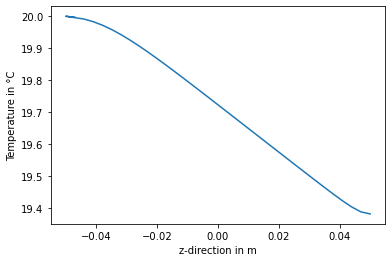

In [4]:
#idx where x is zero
idx_x=np.where(X[:,0]==0)
#idx where y is zero
idx_y=np.where(X[:,1]==0)
#idx where x and y is zero, by comparing the two arrays idx_x and idx_y and only taking the indizes which occurring in both arrays
idx=np.intersect1d(idx_x,idx_y)

#Temperature for the indices where x and y == 0
T_middle=T[idx]
#Z-Coordinates for the indices where x and y ==0
X_z=X[idx,2]

plt.plot(X_z,T_middle)
plt.xlabel('z-direction in m')
plt.ylabel('Temperature in °C')
plt.title('Temperature over z-direction')

So far so good, the result looks pretty promising. At z=-0.05 it has the prescribed temperature of 20°C and it gets cooled down the further it travels top. but if we have a closer look, its seem like the plot is incorrect at the beginning. There lets just plot the array `X_z`:

Text(0.5, 1.0, 'X_z-value over the X_z indices')

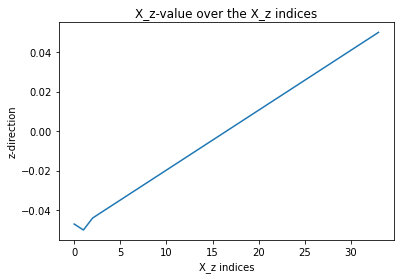

In [5]:
plt.plot(X_z)
plt.ylabel('z-direction')
plt.xlabel('X_z indices')
plt.title('X_z-value over the X_z indices')

It seems like the first and second indices should be switched, as the first entry in X_z[0] does have a higher value that X_z[1]. Therefore we have to sort X_z that it begins with the smallest z-value and ends with the biggest. But we also have to track how the indices are changing. If we dont do this, we cant assign them to the correct temperature.

Text(0.5, 1.0, 'X_z-value over the X_z indices')

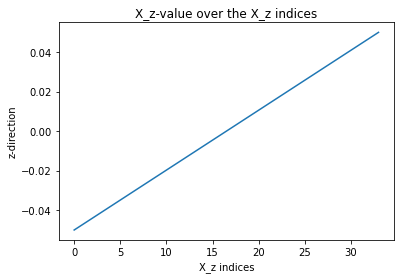

In [6]:
# Lets use np.argsort from numpy-module which is awesome
Idx_sort=np.argsort(X_z)
#Now the array is sorted
X_z=X_z[Idx_sort]
plt.plot(X_z)
plt.ylabel('z-direction')
plt.xlabel('X_z indices')
plt.title('X_z-value over the X_z indices (sorted)')

Nice, now `X_z` is sorted. With the same indices the temperature can be sorted:

Text(0, 0.5, 'Temperature in °C')

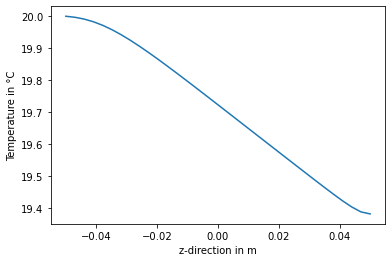

In [7]:
#Sort the T_middle accordingly to X_z
T_middle=T_middle[Idx_sort]
#Lets plot it again
plt.plot(X_z,T_middle)
plt.xlabel('z-direction in m')
plt.ylabel('Temperature in °C')
plt.title('Temperature over z-direction (sorted)')

I hope you learned something. Please keep in mind that in this example we are using only coordinates, where we know a node exists.

Here is the according [Jupyter-notebook](README.ipynb).